In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, "../../code-previous")

In [4]:
import pandas as pd
import numpy as np
import operator

import peakutils

import string
import nltk
stopwords = nltk.corpus.stopwords.words('english')

import operator


import pickle
from sklearn.feature_extraction.text import CountVectorizer

import plotly
import plotly.plotly as py
from plotly import tools

import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='sreejith_s', api_key='rcet0rTqFCc3WeOzWTjv')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

In [5]:
data_path = "/mnt/disks/vault/analysis-data/word-journey/all-data.pql"
data = pd.read_pickle(data_path)

In [6]:
data_astrophy = data[data.Label == "Astronomy & Astrophysics"]
data = None

In [7]:
len(data_astrophy.PubYear.unique())

117

In [8]:
data = data_astrophy[["PubYear","Title","title_without_stopwords"]]

In [9]:
data = data.drop_duplicates()

In [10]:
def num_there(w):
    return any(i.isdigit() for i in w)


def clean_digits(s):
    t = s.split()
    cleaned = " ".join([x for x in t if not num_there(x)])
    return cleaned

data["title_words"] = data["title_without_stopwords"].progress_apply(lambda x: clean_digits(x))

Progress: 100%|██████████| 549847/549847 [00:05<00:00, 99814.10it/s] 


In [11]:
data.head()

,PubYear,Title,title_without_stopwords,title_words
553,1981,SPECTROSCOPIC INVESTIGATION OF ABUNDANCE GRADI...,spectroscopic investigation abundance gradient...,spectroscopic investigation abundance gradient...
1218,1981,A NEW UPPER LIMIT ON THE ELECTRIC-DIPOLE MOMEN...,upper limit electric dipole moment neutron,upper limit electric dipole moment neutron
1250,1981,A POTENTIAL INTER-STELLAR SPECIES - CS+,potential inter stellar species,potential inter stellar species
1885,1981,V923 AQUILAE,v923 aquilae,aquilae
1969,1981,OPTIMIZATION THEORY AND TIME-DOMAIN INVERSE SC...,optimization theory time domain inverse scatte...,optimization theory time domain inverse scatte...


In [12]:
vectorizer = CountVectorizer()
vectorized_words = vectorizer.fit_transform(data.title_words)

In [13]:
count_vocab = {value:key for key,value in vectorizer.vocabulary_.items()}
count_rev_dict = {value:key for key,value in vectorizer.vocabulary_.items()}
words = [count_rev_dict[i] for i in range(len(vectorizer.vocabulary_.keys()))]

__Calculate Document Frequency__

In [14]:
# counting the indices
batch = 1000
document_frequency = []

for i in tqdm(range(0, vectorized_words.shape[1], batch)):
    tmp = vectorized_words[:,i:i+batch].toarray()
    df_tmp = np.count_nonzero(tmp, axis=0)

    df_tmp_list = df_tmp.tolist()
    document_frequency.extend(df_tmp_list)
    
len(document_frequency)

100%|██████████| 48/48 [02:05<00:00,  2.12s/it]


47379

__Calculate Term Frequency__

In [15]:
term_frequency = []
tfs = vectorized_words.sum(axis=0)
term_frequency = tfs.tolist()[0]

In [16]:
term_frequency[39017]

27767

__Word Frequency Graph__

In [17]:
print(words[39017])
print(term_frequency[39017])

solar
27767


In [18]:
x_ = []
y_ = []


for idx in range(len(term_frequency)):
    x_.append(np.log(document_frequency[idx]))
    y_.append(np.log(term_frequency[idx]))


trace = go.Scatter(
    x = x_,
    y = y_,
    mode = 'markers',
    text = words
)



layout= go.Layout(
    title= 'Document Frequency - Term Frequency plot ',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Document Frequency',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Log Term Frequency',
        ticklen= 5,
        gridwidth= 2,
    ),
    
    showlegend= False
)


datatoplot = [trace]

fig= go.Figure(data=datatoplot, layout=layout)
py.iplot(fig)

/usr/local/lib/python3.6/dist-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/usr/local/lib/python3.6/dist-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:


The draw time for this plot will be slow for clients without much RAM.


/usr/local/lib/python3.6/dist-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



__Rank of words in the corpus__

In [19]:
term_frequencies = tfs.reshape(-1,).tolist()[0]

tf_sorted_indices = [i[0] for i in sorted(enumerate(term_frequencies), key=lambda x:x[1], reverse=True)]
tfs_sorted = [term_frequencies[i] for i in tf_sorted_indices]

In [20]:
tf_sorted_indices[:5]

[40003, 39017, 29161, 34684, 15626]

In [21]:
tfs_sorted[0]
words[tfs_sorted[0]]

'notifications'

Text(0,0.5,'Frequency')

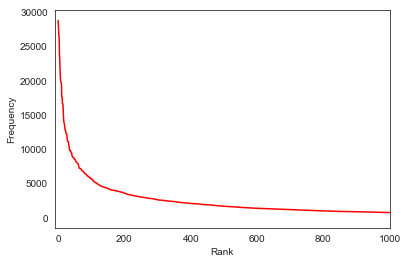

In [22]:
f = plt.figure()

ax = f.add_subplot(111)
ax.plot(tfs_sorted, color='r')
ax.set_xlim(left=-10, right=1000)
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")

In [23]:
zipf_words = [words[i] for i in tf_sorted_indices]
zipf_words[1]

'solar'

In [27]:
trace2 = go.Scatter(
    y = tfs_sorted,
    mode = 'markers',
    text = zipf_words,
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)



layout2 = go.Layout(
    hovermode= 'closest',
    xaxis= dict(
        title= 'Rank',
        ticklen= 5,
        zeroline= False,
        range=[0, 2000],
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'Term Frequency',
        ticklen= 5,
        gridwidth= 2,
    ),
    
    showlegend= False
)


datatoplot2 = [trace2]

fig= go.Figure(data=datatoplot2, layout=layout2)
py.iplot(fig)

/usr/local/lib/python3.6/dist-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.

/usr/local/lib/python3.6/dist-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:


The draw time for this plot will be slow for clients without much RAM.


/usr/local/lib/python3.6/dist-packages/plotly/api/v1/clientresp.py:40: UserWarning:

Estimated Draw Time Slow

/usr/local/lib/python3.6/dist-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

